In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import numpy as np


In [2]:
def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    df = df[df['sentence'].apply(lambda x: len(x.split()) > 3)]
    return df

In [3]:
# Load the dataset
train_data = pd.read_csv('dataset/train.txt', sep=';',  names=['sentence', 'emotion'])
test_data = pd.read_csv('dataset/test.txt', sep=';', names=['sentence', 'emotion'])



remove_small_sentences(train_data)
remove_small_sentences(test_data)

# remove "love" and "surprise" from the dataset
train_data = train_data[train_data['emotion'] != 'love']
train_data = train_data[train_data['emotion'] != 'surprise']

train_data = train_data.dropna()
test_data = test_data.dropna()



# Preprocess the text data
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    tokens = map(Removing_urls, tokens)
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

In [18]:
train_data['preprocessed_sentence'] = train_data['sentence'].apply(preprocess_text)
test_data['preprocessed_sentence'] = test_data['sentence'].apply(preprocess_text)

# Create feature vectors using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['preprocessed_sentence'])
X_test = vectorizer.transform(test_data['preprocessed_sentence'])

# Split the data into training and testing sets
y_train = train_data['emotion']
y_test = test_data['emotion']

['sadness' 'anger' 'fear' 'joy']


In [6]:

# Train a LinearSVC classifier
classifier = LinearSVC(
    C=1.0,

    loss='hinge',
)
classifier.fit(X_train, y_train)

LinearSVC(loss='hinge')

In [17]:
# Make predictions on the test set
import pickle


y_pred = classifier.predict(X_test)
# print x test emotions unique

# Evaluate the model
print(classification_report(y_test, y_pred))

model = {
    'vectorizer': vectorizer,
    'classifier': classifier
}
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

    

              precision    recall  f1-score   support

       anger       0.87      0.88      0.88       275
        fear       0.84      0.87      0.85       224
         joy       0.78      0.98      0.87       695
        love       0.00      0.00      0.00       159
     sadness       0.88      0.92      0.90       581
    surprise       0.00      0.00      0.00        66

    accuracy                           0.83      2000
   macro avg       0.56      0.61      0.58      2000
weighted avg       0.74      0.83      0.78      2000



c:\Users\austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\austi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

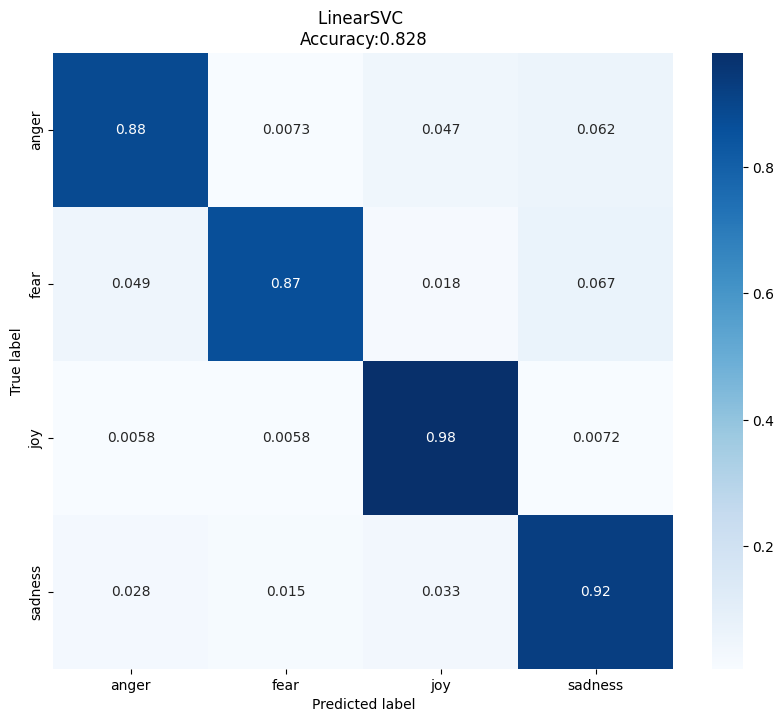

In [9]:
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_, normalize='true')
cm_df = pd.DataFrame(cm, index=classifier.classes_, columns=classifier.classes_)


plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('LinearSVC \nAccuracy:{0:.3f}'.format(classifier.score(X_test, y_test)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

              precision    recall  f1-score   support

       anger       0.93      0.92      0.92       275
        fear       0.92      0.84      0.88       212
         joy       0.96      0.97      0.96       704
     sadness       0.93      0.95      0.94       550

    accuracy                           0.94      1741
   macro avg       0.93      0.92      0.93      1741
weighted avg       0.94      0.94      0.94      1741



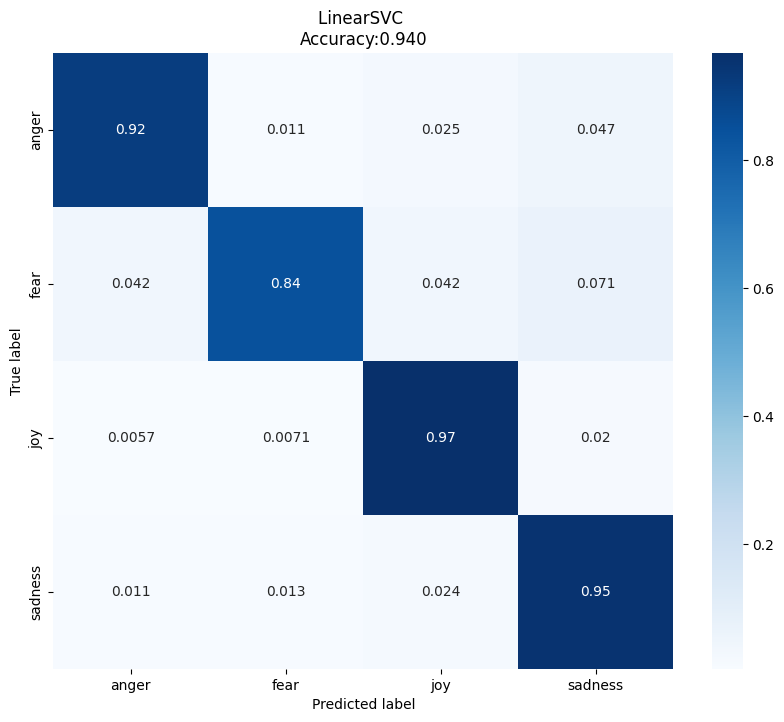

In [10]:
val_data = pd.read_csv('dataset/val.txt',sep=';', names=['sentence', 'emotion'])
val_data = val_data.dropna()
remove_small_sentences(val_data)
val_data = val_data[val_data['emotion'] != 'love']
val_data = val_data[val_data['emotion'] != 'surprise']
val_data['preprocessed_sentence'] = val_data['sentence'].apply(preprocess_text)
X_val = vectorizer.transform(val_data['preprocessed_sentence'])

y_val = val_data['emotion']
y_pred_val = classifier.predict(X_val)

print(classification_report(y_val, y_pred_val))

cm_val = confusion_matrix(y_val, y_pred_val, labels=classifier.classes_, normalize='true')
cm_df_val = pd.DataFrame(cm_val, index=classifier.classes_, columns=classifier.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_val, annot=True, cmap='Blues')
plt.title('LinearSVC \nAccuracy:{0:.3f}'.format(classifier.score(X_val, y_val)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [11]:

import pickle
sentence = "Dear Indians..It is hard to swallow this but for once try to swallow this bitter pill...that is.. Pakistan is number one in Test cricket!!!"

model =  pickle.load(open('model.pkl', 'rb'))
t = preprocess_text(sentence)
classifier = model['classifier']
vectorizer = model['vectorizer']

X = vectorizer.transform([t])
y = classifier.predict(X)
print(y[0])

anger
